In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import vuong_plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
beta0 = 1.
beta1 = .25

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 2000
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.uniform.rvs(loc=-5,scale=10,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs

In [43]:
class Tobit(GenericLikelihoodModel):
    
    def __init__(self, *args,ols=False, **kwargs):
        super(Tobit,self).__init__(*args,**kwargs)
        self.ols = ols

    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        
        beta = params
        
        mu_y = np.matmul(x,beta)
        
        pr_y = stats.norm.logpdf( y, loc = mu_y)
        
        #if complete case, assign pr missing to all observations...
        pr_m = stats.norm.logcdf( y, loc = mu_y)
        
        #we're done if ols
        if self.ols:
            return pr_y
        else:
            ll = (1-m)*pr_y + m*pr_m
            return ll


In [44]:
yn,xn,nobs = gen_data()
model1 =  Tobit(yn,sm.add_constant(xn))
model1_fit = model1.fit(disp=False)
ll1 = model1.loglikeobs(model1_fit.params)

model2 =  Tobit(yn,sm.add_constant(xn),ols=True)
model2_fit = model2.fit(disp=False)
ll2 = model2.loglikeobs(model2_fit.params)

print((ll1-ll2).sum()/ np.sqrt( nobs*(ll1-ll2).var() ))
print( np.sqrt(nobs)*(ll1-ll2).mean()/ (ll1-ll2).std())
print('-----')
print((ll1-ll2).max(),(ll1-ll2).min())
print(xn[(ll1-ll2).argmin()],yn[(ll1-ll2).argmin()])
print(ll1[(ll1-ll2).argmin()],ll2[(ll1-ll2).argmin()])
print('-----')
print(xn[(ll1-ll2).argmax()],yn[(ll1-ll2).argmax()])
print(ll1[(ll1-ll2).argmax()],ll2[(ll1-ll2).argmax()])
print('-----')

#try to cross validate with a test set
yn_cross,xn_cross,nobs = gen_data()
m1_cross = Tobit(yn_cross,sm.add_constant(xn_cross))
m2_cross = Tobit(yn_cross,sm.add_constant(xn_cross),ols=True)

ll1_cross = m1_cross.loglikeobs(model1_fit.params)
ll2_cross = m2_cross.loglikeobs(model2_fit.params)

print( (ll1_cross-ll2_cross).mean() )
print( (ll1_cross-ll2_cross).std()/np.sqrt(nobs) )
print( np.sqrt(nobs)*(ll1_cross-ll2_cross).mean()/ (ll1_cross-ll2_cross).std() )



-6.4433044118926555
-6.4433044118926555
-----
0.4175791032001157 -1.1360008285051055
-4.739540935767611 3.03772141298873
-6.121529359069175 -4.9855285305640695
-----
-4.999873741052044 0.0
-0.5100689903519575 -0.9276480935520732
-----
-0.022047940360688658
0.004227843547005171
-5.214937619039025


In [4]:
def setup_shi(yn,xn):
    model1 = Tobit(yn,sm.add_constant(xn))
    model1_fit = model1.fit(disp=False,xtol=1e-12,ftol=1e-12)
    ll1 = model1.loglikeobs(model1_fit.params)
    grad1 =  model1.score_obs(model1_fit.params)    
    hess1 = model1.hessian(model1_fit.params)

    #fit logistic values
    model2 = Tobit(yn,sm.add_constant(xn),ols=True)
    model2_fit = model2.fit(disp=False,xtol=1e-12,ftol=1e-12)
    ll2 = model2.loglikeobs(model2_fit.params)
    grad2 =  model2.score_obs(model2_fit.params)    
    hess2 = model2.hessian(model2_fit.params)
    return ll1,grad1,hess1,ll2,model1_fit.params, grad2,hess2,model2_fit.params


In [23]:
yn,xn,nobs = gen_data()

ll1,grad1,hess1,ll2,theta1, grad2,hess2,theta2 = setup_shi(yn,xn)
V = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,theta1, grad2,hess2,theta2).sum()
print('------')
print(-1*V.sum()/2)


theta_diff1 =  np.array([(np.array([1, .25]) - theta1)])
print(theta_diff1)
b1 = np.dot(theta_diff1,-1*hess1/nobs)
b1 = np.dot(b1,theta_diff1.transpose())
print(b1*1000)
print(theta2)
#theta_diff2 =  np.array([(np.array([1.15, .19]) - theta2)])
#print(theta_diff2)
b2 = np.dot(theta_diff1,-1*hess2/nobs)
b2 = np.dot(b2,theta_diff2.transpose())
print(b2*1000)

print(nobs*(b1 - b2)[0,0])

[[ 1.13178655 -0.04483276 -0.8526594  -0.03621172]
 [-0.04483276  0.14307119 -0.03731466 -0.10317515]
 [-0.8526594  -0.03731466  0.70363609  0.07381166]
 [-0.03621172 -0.10317515  0.07381166  0.08324433]]
[[-1.04115983 -0.00107179  0.80567346  0.06464021]
 [-0.00788444 -1.04305572  0.53089444  0.77272188]
 [-0.85649224 -0.04823524  0.71144869  0.08262266]
 [-0.38570524 -0.84576718  0.67671397  0.68701244]]
-0.3428772086542893
------
0.3428772086542889
[[ 0.04987619 -0.00024941]]
[[2.31095918]]
[1.11297763 0.19657363]
[[-0.6711708]]
2.982129987720554


[[-331.05899109]] -30.721344015182083
299.416744798391
------
436.76889793503193 190767.07020338235
1.6568191324581596 138048030.74919528
3.3350542293007646 230545769110.4619


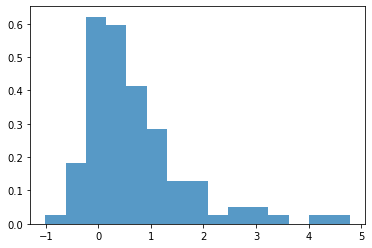

In [13]:
yn,xn,nobs = gen_data()
bootstrap_r = vuong_plots.plot_bootstrap_recenter(yn,xn,nobs,setup_shi,trials=100)
print( np.array(bootstrap_r).mean() )
print('------')
print( np.array(bootstrap_r).std(), stats.moment((bootstrap_r), 2) )
print( stats.skew(bootstrap_r), stats.moment((bootstrap_r), 3) )
print( stats.kurtosis(bootstrap_r),  stats.moment((bootstrap_r), 4) )

In [14]:
yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
print(grad1.sum(axis=0),grad2.sum(axis=0))

[9.01699176e-06 3.09940227e-05] [-1.73478999e-05 -1.01205617e-05]


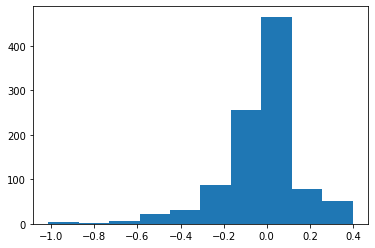

-29.068723297683796
0.17564756393817998 0.030852066717417023
-0.9733079223677243 -0.00527444358075043
3.713507291456387 0.006390252054583722


In [15]:
yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)

V = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2)
tr_Vsq = (V*V).sum()
V_nmlzd = V/np.sqrt(tr_Vsq) #V, normalized by sqrt(trVsq);
bootstrap_stats = vuong_plots.plot_bootstrap_pt(yn,xn,nobs,setup_shi,trials=300)


plt.clf()
plt.hist(ll1-ll2)
plt.show()

print( (ll1-ll2).sum() )
print( (ll1-ll2).std(), stats.moment((ll1-ll2), 2) )
print( stats.skew(ll1-ll2), stats.moment((ll1-ll2), 3) )
print( stats.kurtosis(ll1-ll2),  stats.moment((ll1-ll2), 4) )

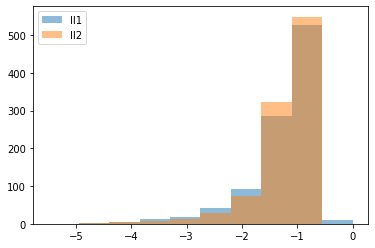

------
0.5882027162788386 0.39894227919114855
0.0 -4.941985384422358
0.8329702914091822 -1.3584803253910174
------
0.009886252684035616 0.008193212746756223
3.2840794160864006 -1.6374327125434074
4.8403717417792524 4.9774040683283935
-------
-3.694111712368654 -2.015758409428757 -1.4100524606172335 -1.0712345089107655 -0.940840996008393 -0.7161660225871931
-3.377857996031391 -1.8197834662792602 -1.3423679511614903 -1.0674336495060452 -0.956489818156738 -0.921770239659479
-------
-29.068723297683796
--------


In [16]:
plt.show()
plt.hist(ll1,label='ll1',range=(-5.5,0),alpha=.5)
plt.hist(ll2,label='ll2',range=(-5.5,0),alpha=.5)
plt.legend()
plt.show()


print('------')


print(np.exp(ll1.max()),np.exp(ll2.max()))
print(yn[ll1.argmax()],xn[ll1.argmax()])
print(yn[ll2.argmax()],xn[ll2.argmax()])
print('------')

print(np.exp(ll1.min()),np.exp(ll2.min()))
print(yn[ll1.argmin()],xn[ll1.argmin()])
print(yn[ll2.argmin()],xn[ll2.argmin()])

print('-------')
print(np.quantile(ll1,.01),np.quantile(ll1,.1),np.quantile(ll1,.25),np.quantile(ll1,.5),np.quantile(ll1,.75),np.quantile(ll1,.95))
print(np.quantile(ll2,.01),np.quantile(ll2,.1),np.quantile(ll2,.25),np.quantile(ll2,.5),np.quantile(ll2,.75),np.quantile(ll2,.95))

print('-------')
print( (ll1-ll2).sum() )
print('--------')
#print(V_nmlzd.sum(),V.sum())
#print((ll1-ll2).sum()/np.sqrt((ll1-ll2).var()*nobs))

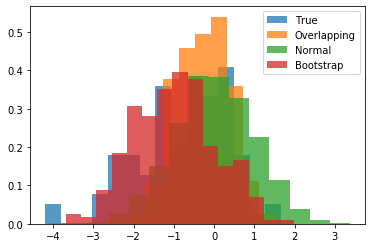

In [17]:
beta0 = 1.
beta1 = .25

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 500
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs

true_stats = vuong_plots.plot_true2(gen_data,setup_shi,trials=100)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_pt(yn,xn,nobs,setup_shi,trials=300)
plt.legend()
#plt.savefig('../figs/tobit_plot25.png')
plt.show()

In [18]:
overlap,normal = anayltic_stats

#print moments/kstats
print(' --------')
for distr in [true_stats,overlap,normal,bootstrap_stats]:
    print('--------- ')
    print(1, np.array(distr).mean(), stats.kstat(distr, 1))
    print(2, np.array(distr).var(), stats.kstat(distr, 2))
    print(3, stats.skew(distr), stats.kstat(distr, 3) )
    print(4, stats.kurtosis(distr),  stats.kstat(distr, 4) )
    print('--------- ')
print('---------')


ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
thing1 = np.array(true_stats).mean() - np.array(bootstrap_stats).mean()
print(thing1)
thing2 = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2).sum()
print(thing2)
print(thing1/thing2)

 --------
--------- 
1 -0.7348519377573759 -0.7348519377573759
2 1.2402381773532796 1.2527658357103837
3 -0.5579475611086846 -0.794309500292967
4 0.10850788005893675 0.27719475238849967
--------- 
--------- 
1 -0.27790431207225147 -0.27790431207225147
2 0.4345630666791333 0.43464999667846904
3 -0.18015031394822523 -0.05163864799421146
4 -0.016157073443324954 -0.0028285726951941185
--------- 
--------- 
1 0.008473590281466046 0.008473590281466046
2 0.9763373364527029 0.9765326429812992
3 -0.07618973040575247 -0.07354563523098416
4 -0.04050795690091746 -0.03752243749319041
--------- 
--------- 
1 -0.9831260645286951 -0.9831260645286951
2 1.020675527753872 1.0240891582814766
3 0.05225847229688916 0.05443062481572302
4 -0.27391696762282836 -0.27086061607119005
--------- 
---------
0.24827412677131921
-0.0005204995466502609
-476.99201347843245
